### If you downloaded the zip folder with processed data, unzip with following code

In [3]:
import zipfile
with zipfile.ZipFile("data/processed.zip","r") as zip_ref:
    zip_ref.extractall("data/")

### Define training steps

For simplicity in the cloud setup, helper functions are defined in this code block too

In [1]:
import sys
sys.path.insert(0, "/home/jovyan/examples/examples/dask-gpu-experiment/")
import pandas as pd
import uuid
import os
import datetime
import pickle
import time
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler

from dask_pytorch_ddp import dispatch, results
from dask_saturn import SaturnCluster
from dask.distributed import Client
from distributed.worker import logger

from sklearn.utils import shuffle

import monai
from monai.losses import FocalLoss
import torchio as tio
import torchio.transforms as transforms
from monai.networks.nets.resnet import resnet10, resnet18, resnet50
from monai.transforms import (
    RandFlip,
    RandRotate,
    Rand2DElastic,
    RandZoom,
    NormalizeIntensity,
    RandGaussianSmooth,
)

import json

#set different logger for different uses
def log_metric(type_, msg, logger, *arg):
    type_ = type_.replace("_", " ")
    logger.info(f"{type_} is {msg} {arg}")
    
    from sklearn.utils import shuffle

class MRIDataset(Dataset):
    """
    Implements __getitem__ method to get items for batches
    Attributes
    ----------
    image_path (string): Path to the image folder
    test_path (string: Path to where tabular data is stored
    annotation_path (string): path to annotation where label is stored
    transform (object, callable): Optional transform to be applied
        on a sample.
    labels: labels extracted from annotation_path
    images: iterable list of paths to all images (could also be images themselves)
    test_results: test results extracted from test_path
    ----------
    Methods
    ----------
    forward(images): takes images and does forward feed calculation
    """
    def __init__(self, df, data, shuffle_ = True, transform=None):
        """
        Parameters:
            image_path (string): Path to the image folder
            test_path (string: Path to where tabular data is stored
            annotation_path (string): path to annotation where label is stored
            transform (object, callable): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # fixme should be handled in another way. maybe in configuration file?
        self.idx_to_label = {
            'CN': 0,
            'MCI': 1,
            'AD': 2
        }

        self.df = df
        self.data = data
        
        if shuffle_ == True:
            self.df = shuffle(self.df)

    def __len__(self):
        """
        returns amount of images in total
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Parameters:
            idx (int): index to image
        """
        img = self.data[self.df.iloc[idx].filename]
        #img = tio.ScalarImage(os.getcwd() + "/" + self.df.iloc[idx].filename)
        img = img.data
        #get image and caption by id
        label = self.df.iloc[idx].Group
        label = self.idx_to_label[label]
        label = nn.functional.one_hot(torch.tensor(label), num_classes = 3).to(torch.float32)
                
        if self.transform is not None:
            try:
                img = self.transform(img)
            except FloatingPointError:
                print(f"img {self.df.iloc[idx].filename} couldn't be transformed, floating point error: overflow encountered in float_scalars")

        img = img[0]
        return {"images": img, "labels": label } #, test_results
    
    def permute(self):
        self.permutation = torch.randperm(len(self.df))

def train(train_data, test_data):
    model = resnet50(spatial_dims=2, n_input_channels =1, num_classes =3)

    class_names = ['CN', 'MCI', 'AD']
    EPOCHS = 3
    WEIGHT_DECAY: 0.15
    LEARNING_RATE = 0.001
    BATCH_SIZE = 8
    
    #---------------------------------
    
    train_transform = transforms.Compose(
        [
            RandGaussianSmooth(prob=0.5),
            RandRotate(prob=0.5),
            RandFlip(prob=0.4),
        ]
    )

    train_dataset = MRIDataset(train_data, data, transform=train_transform)
    #test_dataset = MRIDataset(test_data, data, transform=None)
    
    # the distributed sampler makes it so the samples are distributed across the different workers
    sampler1 = DistributedSampler(train_dataset)
    #sampler2 = DistributedSampler(test_dataset)
    
    worker_rank = int(dist.get_rank())
    device = torch.device(0)

    logger.info(f"Worker {worker_rank} - beginning")
    print(worker_rank)

    model = model.to(device)
    model = DDP(model)

    test_transform = None

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler = sampler1)
    #test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler = sampler2)

    criterion = FocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.15)

    train_epoch_times = []
    test_epoch_times = []
    
    for epoch in range(EPOCHS):
        
        logger.info(
            f"Worker {worker_rank} - {datetime.datetime.now().isoformat()} - Beginning epoch {epoch}"
        )

        # this ensures the data is reshuffled each epoch
        sampler1.set_epoch(epoch)
        train_dataset.permute()

        start_epoch = time.time()
        
        #train------------------
        
        model.train()
        train_loss = 0
        train_total = 0
        train_correct = 0

        for batch_idx, batch in enumerate(train_dataloader):
            data, target = batch["images"].to(device), batch["labels"].to(device)

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)

            train_loss += loss.item()
            scores, predictions = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += int(sum(predictions == torch.argmax(target, dim=1)))
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        acc = round((train_correct / train_total) * 100, 2)
        log_metric("Epoch [{}], Loss: {}, Accuracy: {}".format(epoch, train_loss / train_total, acc), "", logger)
        log_metric('train_acc', acc, logger)
        log_metric('train_loss', train_loss, logger)
        log_metric('train_loss_ma', train_loss/train_total, logger)
        
        #endtrain----------------
        
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        train_epoch_times.append(elapsed)
        log_metric('train_epoch_time', elapsed, logger, "s")

        start_epoch = time.time()
        
        #test--------------------
        
        """model.eval()
        # test model
        test_loss = 0
        test_total = 0
        test_correct = 0

        y_true = []
        y_pred = []
        y_proba = None

        with torch.no_grad():
            for batch_idx, batch in enumerate(test_dataloader):
                inputs, labels = batch["images"].to(device), batch["labels"].to(device)

                outputs = model(inputs)

                test_loss += criterion(outputs, labels).item()
                scores, predictions = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += int(sum(predictions == torch.argmax(labels, dim=1)))

                outputs = outputs.cpu()
                if y_proba is None:
                    y_proba = outputs
                else:
                    y_proba = np.vstack((y_proba, outputs))

                for i in labels.tolist():
                    y_true.append(i)
                for j in predictions.tolist():
                    y_pred.append(j)

        if return_prediction:
            return y_true, y_pred, y_proba

        acc = round((test_correct / test_total) * 100, 2)
        log_metric("Test_loss: {}, Test_accuracy: {}".format(test_loss / test_total, acc), "", logger)
        log_metric('test_acc', acc, logger)
        log_metric('test_loss', test_loss, logger)
        log_metric('test_loss_ma', test_loss/test_total, logger)
        
        #endtest------------------
        
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        test_epoch_times.append(elapsed)
        log_metric('test_epoch_time', elapsed, logger, "s")"""
        
        # the first rh call saves a json file with the loss from the worker at the end of the epoch
        rh.submit_result(
            f"logs/data_{worker_rank}_{epoch}.json",
            json.dumps(
                {
                    "loss": loss.item(),
                    "time": datetime.datetime.now().isoformat(),
                    "epoch": epoch,
                    "worker": worker_rank,
                }
            ),
        )

        # this saves the model. We only need to do it for one worker (so we picked worker 0)
        if worker_rank == 0:
            rh.submit_result("model.pkl", pickle.dumps(model.state_dict()))

train_data = pd.read_csv('./train_labels.csv')
test_data = pd.read_csv('./test_labels.csv')
#y_true, _, y_proba = nn_test(net, device, test_dataloader, criterion, class_names, return_prediction=True)

### Define SaturnCluster and the DaskResultsHandler as callback

In [ ]:
cluster = SaturnCluster()
client = Client(cluster)

key = uuid.uuid4().hex
rh = results.DaskResultsHandler(key)
client

### Send all Images to Cluster and start training

In [ ]:
client.restart()
cluster.scale(8)

import dask_image.imread

train_images = {}
for i in range(len(train_data)):
    img = tio.ScalarImage(os.getcwd() + "/" + train_data.iloc[i].filename).data
    train_images[train_data.iloc[i].filename] = img
    
test_images = {}
for i in range(len(test_data)):
    img = tio.ScalarImage(os.getcwd() + "/" + test_data.iloc[i].filename).data
    test_images[test_data.iloc[i].filename] = img
    
from sys import getsizeof
print("size of all images to be distributed: ", getsizeof(images), "Bytes")    

client.wait_for_workers(8)

futures = dispatch.run(client, train, train_data = train_images, test_data = test_images)

rh.process_results("/home/jovyan/project/training/", futures, raise_errors=False)

In [11]:
images[train_data.iloc[0].filename]

tensor([[[[-0.9194, -0.9194, -0.9194,  ..., -0.9194, -0.9194, -0.9194],
          [-0.9194, -0.9194, -0.9194,  ..., -0.9194, -0.9194, -0.9194],
          [-0.9194, -0.9194, -0.9194,  ..., -0.9194, -0.9194, -0.9194],
          ...,
          [-0.9194, -0.9194, -0.9194,  ..., -0.9194, -0.9194, -0.9194],
          [-0.9194, -0.9194, -0.9194,  ..., -0.9194, -0.9194, -0.9194],
          [-0.9194, -0.9194, -0.9194,  ..., -0.9194, -0.9194, -0.9194]]]])

In [4]:
client.close()

### Load Model:

In [5]:
model_state = pickle.load(open("/home/jovyan/project/training/model.pkl", "rb"))
model = torch.nn.DataParallel(resnet50(spatial_dims=2, n_input_channels =1, num_classes =3)).cuda()
model.load_state_dict(model_state)

<All keys matched successfully>

### Predict class of one image: 

Prediction:  MCI
Actual Diagnosis:  CN


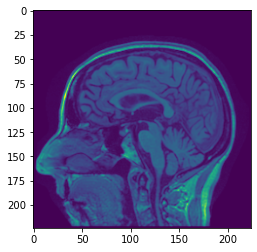

In [12]:
import matplotlib.pyplot as plt

img = images[train_data.iloc[1330].filename]
plt.imshow(img.squeeze())

out = model(img)

class_names = ['CN', 'MCI', 'AD']
prediction = class_names[torch.argmax(out).item()]
print("Prediction: ", prediction)
print("Actual Diagnosis: ", train_data.iloc[1330].Group)